# Checkpoint 5

Objective:

In this test, you're challenged to predict the authorship of excerpts from horror stories by Edgar Allan Poe (`EAP`), Mary Shelley (`MWS`) and HP Lovecraft (`HPL`).

## Import libs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import string

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /home/ivyna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ivyna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ivyna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Import data

In [3]:
data = pd.read_csv('../TrainingSet/text-authorship-training.csv')
data.head()

,id,text,author
0,id15709,The occupation is often full of interest and h...,EAP
1,id18229,"Tall, thin, and strait, her face still handsom...",MWS
2,id10092,"What men attempt to embody in the word ""though...",EAP
3,id05976,They will scarcely be so weak as not to 'reali...,EAP
4,id19298,"There dwelt in that ghastly and flexible face,...",HPL


## Exploratory data analysis

Before applying NLP concepts to the checkpoint, let's get to know a little bit of data by exploring it.

In [4]:
data.describe()

,id,text,author
count,16644,16644,16644
unique,16644,16644,3
top,id25304,I've seen Wilbur Whateley's diary and read som...,EAP
freq,1,1,6691


You can see that there are 16644 lines in the data and with 3 types of authors, namely: `EAP`, `MWS` and `HPL`, as described in the objectives.

### Given this, how about looking at the distribution of the authors?

<AxesSubplot:xlabel='author', ylabel='count'>

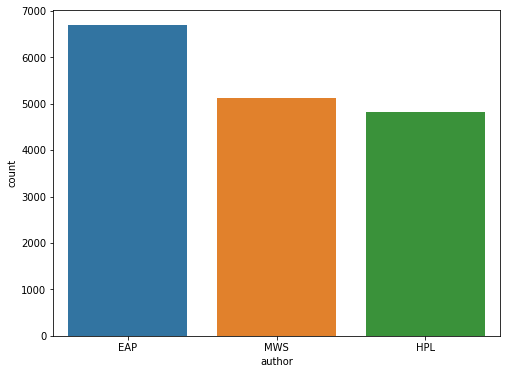

In [5]:
plt.figure(figsize = (8,6))
sns.countplot(data.author)

In the data, there is a greater number of texts by the author EAP, followed and MWS, with a difference of about 1500 texts, and finally HPL, with a difference of more or less than 300 texts.

### How about observing which words are more present in the texts of each author?

In [6]:
word_cloud = data['text']

#### Edgar Allan Poe

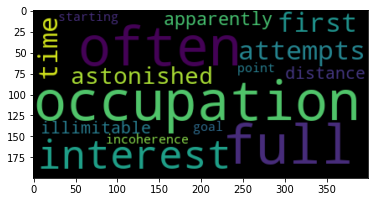

In [7]:
wordcloud_eap = WordCloud().generate(word_cloud[0])
plt.imshow(wordcloud_eap, 
           interpolation = 'bilinear')
plt.show()

#### HP Lovecraft

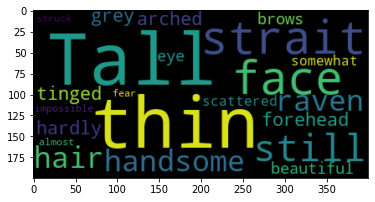

In [8]:
wordcloud_hpl = WordCloud().generate(word_cloud[1])
plt.imshow(wordcloud_hpl, 
           interpolation = 'bilinear')
plt.show()

#### Mary Shelley

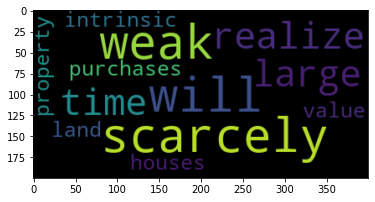

In [9]:
wordcloud_mws = WordCloud().generate(word_cloud[3])
plt.imshow(wordcloud_mws, 
           interpolation = 'bilinear')
plt.show()

### Transform data

After knowing a little about the data, we will apply the NLP concepts to solve the checkpoint.

To make the classification more accurate, it is necessary to perform some treatments on the data, such as removing stopwords, removing punctuation and transforming the words that remain with these "filters" into tokens.

In [10]:
def remove_stopwords(msg):
    """
    Remove stopwords
    
    Args:
        msg: text string
        
    Return:
        Remove all stopwords
    """
    
    return [word for word in msg if not word in stopwords.words('english')]


def remove_pt(msg):
    """
    Remove punctuation of message.
    
    Args:
        message: text string
    Return:
        Messages without ponctuation
    """
    
    return [word for word in msg if not word in string.punctuation]

    
def tokenize_messages(msg):
    """ 
    Tokenize messages
    
    Args:
        msg: text string
    Return:
        Tokenized messages
    """
    
    stopwords.words('english')
    tokens = word_tokenize(msg) 
    del_sw = remove_stopwords(tokens)
    del_pt = remove_pt(del_sw)

    return " ".join([word.lower() for word in del_pt])


def count_vectorizer(count_vec, data):
    vec_transform = count_vec.fit_transform(data.stem_message)
    return pd.DataFrame(vec_transform.toarray())
    

def stemming(msg):
    """
    Stemed messages
    
    Args:
        msg: text string
    Return:
        Stemmed message
    """
    
    lem = nltk.WordNetLemmatizer()
    
    return " ".join([lem.lemmatize(word) for word in msg.split()])

In [11]:
data['token_message'] = data['text'].apply(lambda x: tokenize_messages(x))
data['stem_message'] = data['token_message'].apply(lambda x: stemming(x))
data.head()

,id,text,author,token_message,stem_message
0,id15709,The occupation is often full of interest and h...,EAP,the occupation often full interest attempts fi...,the occupation often full interest attempt fir...
1,id18229,"Tall, thin, and strait, her face still handsom...",MWS,tall thin strait face still handsome raven hai...,tall thin strait face still handsome raven hai...
2,id10092,"What men attempt to embody in the word ""though...",EAP,what men attempt embody word `` thought '' mat...,what men attempt embody word `` thought '' mat...
3,id05976,They will scarcely be so weak as not to 'reali...,EAP,they scarcely weak 'realize time large purchas...,they scarcely weak 'realize time large purchas...
4,id19298,"There dwelt in that ghastly and flexible face,...",HPL,there dwelt ghastly flexible face shone bodile...,there dwelt ghastly flexible face shone bodile...


Data is present in the form of text only. For that, by some means, textual data needs to be transformed into numeric form. Here, the strategy of bag-of-words.


In [13]:
count_vec = CountVectorizer()

In [14]:
vec_transform = count_vec.fit_transform(data.stem_message)
count_vec_df = pd.DataFrame(vec_transform.toarray())

In [15]:
count_vec_data = pd.concat([data, count_vec_df], 
                           axis = 1, 
                           sort = False)

count_vec_data.drop(['id', 'text', 'author', 'token_message','stem_message'], 
                    axis = 1, 
                    inplace = True)

## Train data

To conduct the training, we will share the train data.

In [16]:
text_train, text_test, label_train, label_test = train_test_split(count_vec_data, 
                                                                  data['author'], 
                                                                  test_size = 0.2)

Here the naive baiyes was used as a classifier, as it is an algorithm widely used for classification in solutions for NLP due to its simplicity and high performance.

In [17]:
model = MultinomialNB()
model.fit(text_train, label_train)

MultinomialNB()

In [18]:
model_pred = model.predict(text_test)

After training, it is interesting to observe some metrics and check the model's accuracy.

In [19]:
precision, recall, fscore, _ = score(label_test, 
                                     model_pred)

print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 score: {}'.format(fscore))

Precision: [0.84182099 0.87220447 0.79433272]
Recall: [0.81722846 0.83486239 0.85784798]
F1 score: [0.82934246 0.853125   0.82486948]


We can see that there are results, no label has been defined in the parameter `pos_label`. In view of the values obtained, we have good results in the three parameters analyzed, all above 80%.

Then, we have the calculation and result of the model's accuracy, which in turn is also a good result, above 80%.

In [20]:
acc = round((model_pred == label_test).sum() / len(model_pred), 4) * 100
print('Accuracy: {}%'.format(acc))

Accuracy: 83.48%


## Test data

A set of test data has been made available.

### Import test data

In [21]:
data_test = pd.read_csv('../TestSet/text-authorship-test.csv')
data_test.head()

,id,text
0,id26305,"This process, however, afforded me no means of..."
1,id17569,It never once occurred to me that the fumbling...
2,id11008,"In his left hand was a gold snuff box, from wh..."
3,id27763,How lovely is spring As we looked from Windsor...
4,id12958,"Finding nothing else, not even gold, the Super..."


In the test data set, operations to remove stopwords, punctuation and word tokerization are also performed.

In [22]:
data_test['token_message'] = data_test['text'].apply(lambda x: tokenize_messages(x))
data_test['stem_message'] = data_test['token_message'].apply(lambda x: stemming(x))

In [23]:
count_vec_test = count_vec.transform(data_test.stem_message)
count_vec_test_df = pd.DataFrame(count_vec_test.toarray())

In [24]:
data_test.drop(['stem_message'],
               axis = 1, 
               inplace = True)

count_vec_data_test = pd.concat([data_test, count_vec_test_df], 
                            axis = 1, 
                            sort = False)

count_vec_data_test.drop(['id', 'text', 'token_message'], 
                         axis = 1, 
                         inplace = True)

In [25]:
result = {
    "author": [], 
    "text": data_test.text
}

Using the naive baiyes model previously trained, the author of the text is predicted with the test data set and create the answer file.

In [26]:
pred_test = model.predict(count_vec_data_test)

In [27]:
result["author"] = pred_test
rp = pd.DataFrame(result)

In [28]:
rp.to_csv('../data/author_detection.csv', 
          index = False)